# Testing a baseline model

## Loading a model

In [1]:
import tensorflow as tf

In [2]:
import tensorflow
vgg_model = tensorflow.keras.applications.vgg16.VGG16(include_top=False, input_shape=(224, 224, 3))

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential(
    vgg_model.layers + 
    [
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

In [4]:
assert model.count_params() == 17926209

In [5]:
vgg_model.trainable=False

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

## Loading latest checkpoint 

In [7]:
import os
checkpoint_path = "models/checkpoint"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.listdir(checkpoint_dir)

['checkpoint',
 'cp.ckpt.data-00000-of-00001',
 'cp.ckpt.index',
 'model.pkl',
 'old baseline']

In [8]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'models\\cp.ckpt'

In [9]:
# Load the previously saved weights
model.load_weights(latest)

In [10]:
# import pickle
# filename = 'training_1\\model.pkl'
# loaded_model = pickle.load(open(filename, 'rb'))

## Evaluating the model on mixed test data (good vs bad + confidence) on our own private colleciton

In [11]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def pred(img_fname):
    img = image.load_img(img_fname, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    pred = model.predict(x)[0][0]
    return pred

In [13]:
def evaluate(img_fname, threshold=0.5):
    img = image.load_img(img_fname, target_size=(224, 224))
    score = pred(img_fname)
    score_class = 'good' if score > threshold else 'bad'
    score = score if score_class == 'good' else 1 - score
    print('Predicted:', score_class, 'with prediction (confidence) of ' + str(round(score, 3)))
    plt.imshow(img)
    plt.show()

In [14]:
folder = 'test\\organic mixed (good and bad)\\'
test_files = os.listdir(folder)
print('Totel number of images on the test set is', len(test_files))

Totel number of images on the test set is 20


Predicted: bad with prediction (confidence) of 0.839


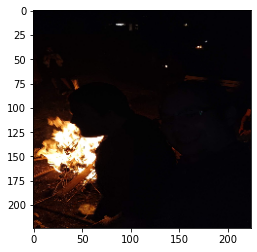

Predicted: bad with prediction (confidence) of 1.0


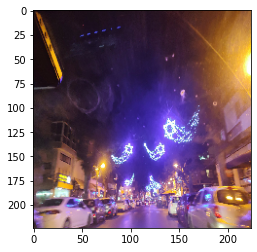

Predicted: good with prediction (confidence) of 1.0


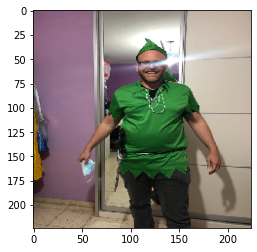

Predicted: bad with prediction (confidence) of 0.577


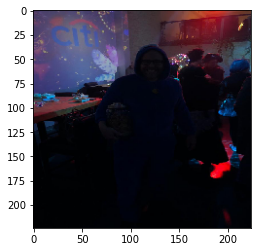

Predicted: bad with prediction (confidence) of 0.985


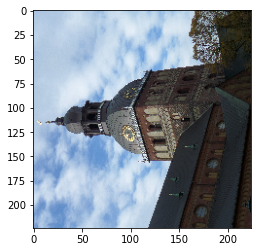

Predicted: good with prediction (confidence) of 1.0


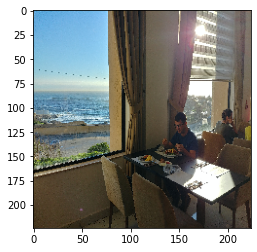

Predicted: bad with prediction (confidence) of 0.967


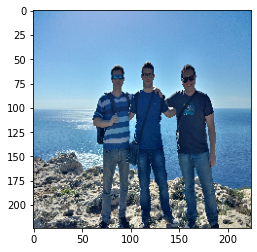

Predicted: good with prediction (confidence) of 1.0


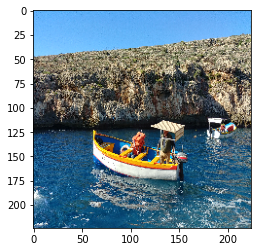

Predicted: good with prediction (confidence) of 1.0


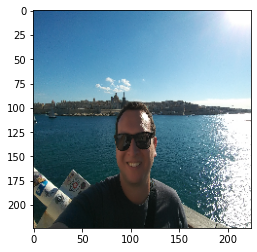

Predicted: good with prediction (confidence) of 0.996


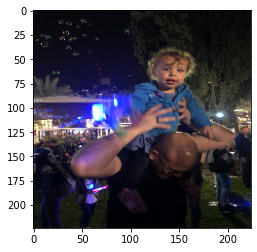

Predicted: bad with prediction (confidence) of 0.998


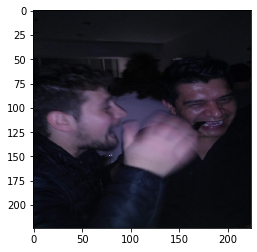

Predicted: good with prediction (confidence) of 1.0


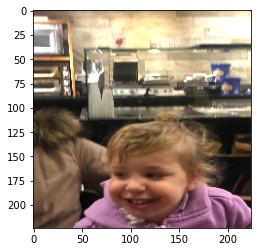

Predicted: good with prediction (confidence) of 1.0


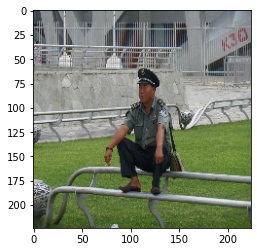

Predicted: good with prediction (confidence) of 1.0


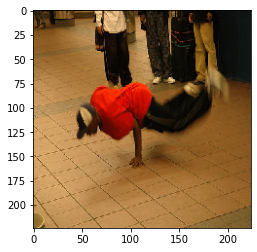

Predicted: good with prediction (confidence) of 0.528


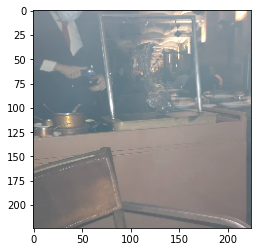

Predicted: bad with prediction (confidence) of 0.998


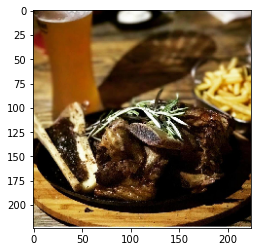

Predicted: bad with prediction (confidence) of 0.998


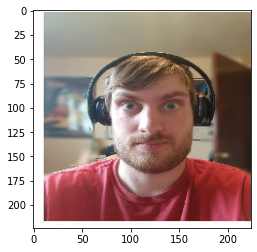

Predicted: good with prediction (confidence) of 1.0


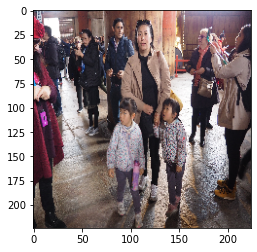

Predicted: bad with prediction (confidence) of 0.617


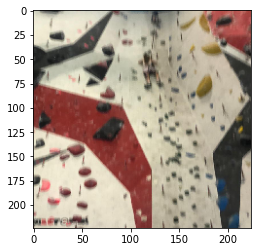

Predicted: bad with prediction (confidence) of 0.958


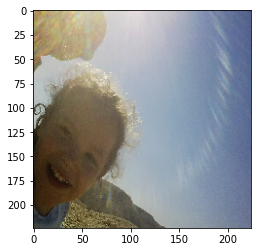

In [15]:
for filename in test_files:
    evaluate(folder + filename)

In [16]:
photo_score = dict()
for filename in test_files:
    photo_score[filename] = pred(folder + filename)

### Separating the good and good averaged scored photos from the best scored photos (by a threshold)

In [17]:
def show_photos(photos_list):
    for img_name in photos_list:
        img = image.load_img(folder + img_name, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        print(img_name)
        plt.imshow(img)
        plt.show()

In [18]:
good_photos = {k:v for (k,v) in photo_score.items() if (v > 0.5) & (v < 0.9)}
best_photos = {k:v for (k,v) in photo_score.items() if v >= 0.9}

In [19]:
print('Good photos (0.5 < threshold < 0.9): ', len(good_photos))
print('Best photos (threshold >= 0.9): ', len(best_photos))

Good photos (0.5 < threshold < 0.9):  1
Best photos (threshold >= 0.9):  9


#### Good average scored photos (score between 0.5 and 0.9)

4.jpg


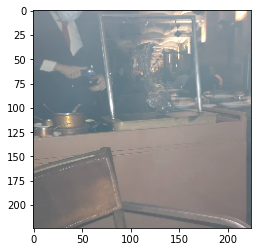

In [20]:
show_photos(good_photos)

#### Best scored photos (score over 0.9)

11.jpg


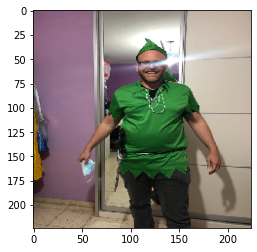

14.jpg


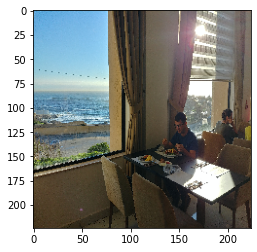

16.jpg


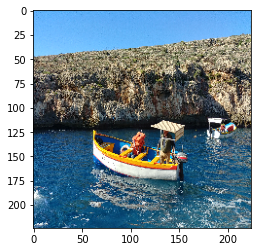

17.jpg


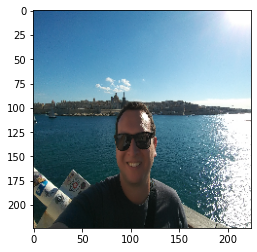

18.jpg


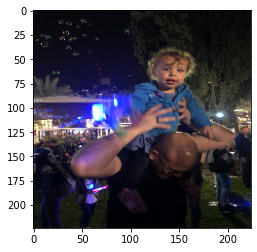

2.jpg


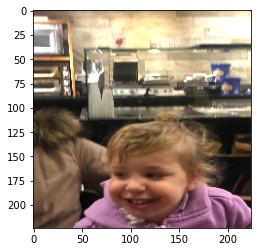

20.JPG


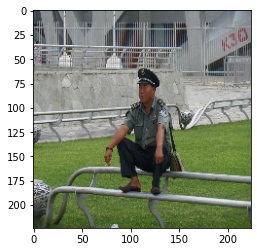

3.jpg


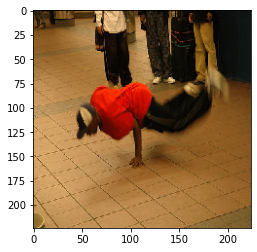

7.JPG


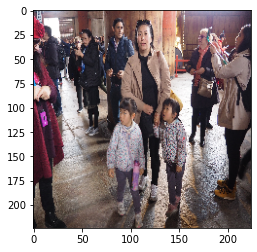

In [21]:
show_photos(best_photos)

### Worst scored photos (score equal and below 0.5)

In [22]:
worst_photos = {k:v for (k,v) in photo_score.items() if v <= 0.5}

In [23]:
print('Worst photos (threshold <= 0.5): ', len(worst_photos))

Worst photos (threshold <= 0.5):  10


1.jpg


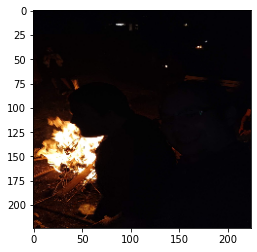

10.jpg


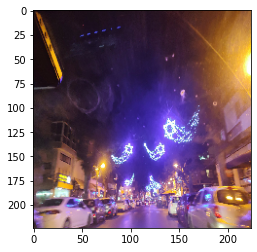

12.jpg


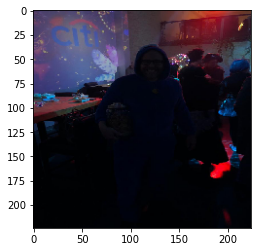

13.JPG


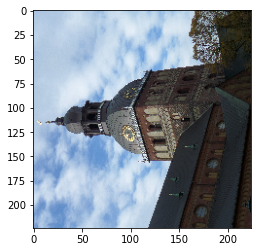

15.jpg


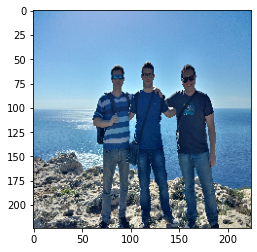

19.jpg


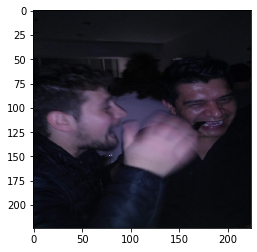

5.jpg


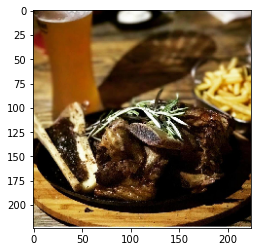

6.jpg


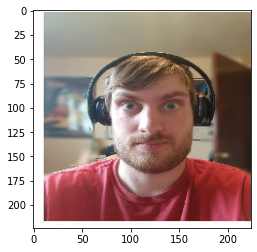

8.jpg


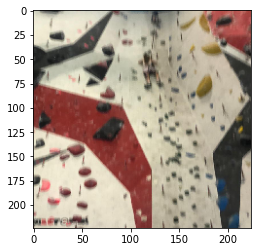

9.jpg


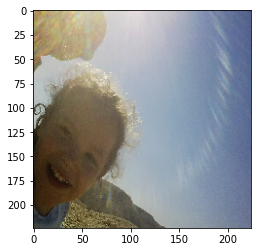

In [24]:
show_photos(worst_photos)

### Two samples of the highest score photos and the lowest score photos

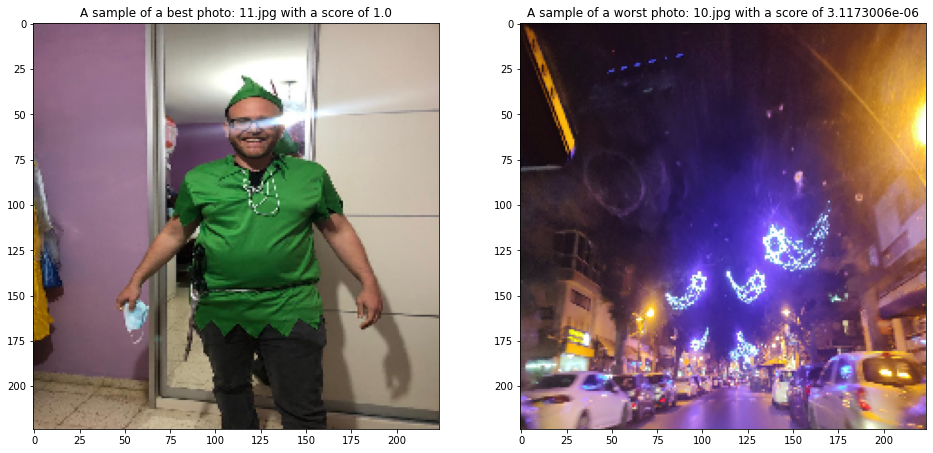

In [25]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 16 ,8

highest_score_photo = max(photo_score, key= lambda x: photo_score[x])

img = image.load_img(folder + highest_score_photo, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
plt.subplot(1, 2, 1)
plt.title('A sample of a best photo: ' + highest_score_photo + ' with a score of ' + str(photo_score[highest_score_photo]))
plt.imshow(img)

lowest_score_photo = min(photo_score, key= lambda x: photo_score[x])

img = image.load_img(folder + lowest_score_photo, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
plt.subplot(1, 2, 2)
plt.title('A sample of a worst photo: ' + lowest_score_photo + ' with a score of ' + str(photo_score[lowest_score_photo]))
plt.imshow(img);

###  All of the highest score photos

In [26]:
highest_score_photos = [k for k, v in photo_score.items() if v == photo_score[highest_score_photo]]
print('There are ' + str(len(highest_score_photos)) + ' best scored photos with a score of ' + str(photo_score[highest_score_photo]))
# show_photos(highest_score_photos)

There are 2 best scored photos with a score of 1.0


### All of the lowest score photos

In [27]:
lowest_score_photos = [k for k, v in photo_score.items() if v == photo_score[lowest_score_photo]]
print('There are ' + str(len(lowest_score_photos)) + ' worst scored photos with a score of ' + str(photo_score[lowest_score_photo]))
# show_photos(lowest_score_photos)

There are 1 worst scored photos with a score of 3.1173006e-06


## Testing the model on organic test data (our private collection)

In [28]:
threshold = 0.795

In [29]:
from keras.preprocessing.image import ImageDataGenerator
img_gen = ImageDataGenerator(validation_split=0.2)

In [30]:
test_data = img_gen.flow_from_directory(
    'test\\organic',
    target_size=(224, 224),
    class_mode=None,
    shuffle=False,
)

Found 176 images belonging to 2 classes.


In [31]:
pred = model.predict_generator(generator=test_data)

C:\Users\Eran\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [32]:
y_true = test_data.classes
y_pred = pred > threshold

### Confusion matrix

In [33]:
from sklearn.metrics import confusion_matrix

font = {
'family': 'Arial',
'size': 22
}
plt.rc('font', **font)
mat = confusion_matrix(y_true, y_pred)

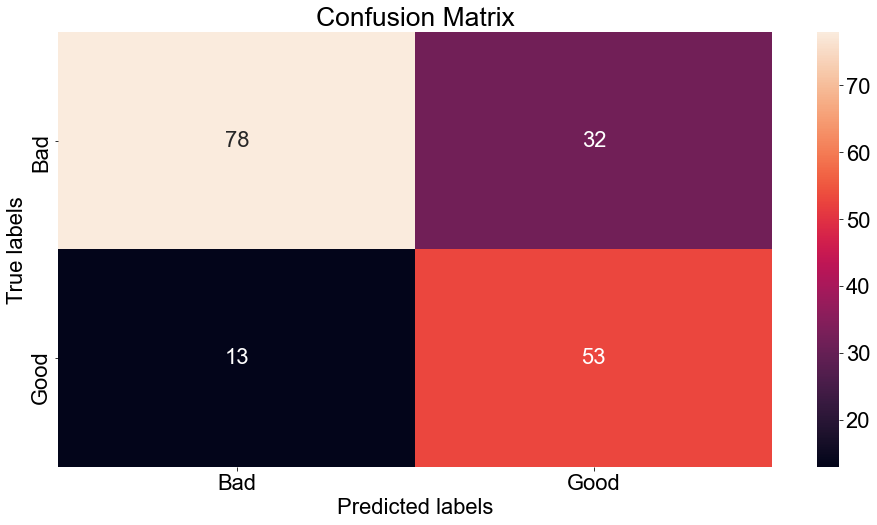

In [34]:
import seaborn as sns

ax= plt.subplot()
sns.heatmap(mat, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Bad', 'Good']); ax.yaxis.set_ticklabels(['Bad', 'Good']);

In [35]:
FP = mat[0][1]
FN = mat[1][0]
FP_rate = FP / (mat[0][0] + mat[0][1])
FN_rate = FN / (mat[1][0] + mat[1][1])
print('False Positive rate:', FP_rate)
print('False Negative rate:', FN_rate)

False Positive rate: 0.2909090909090909
False Negative rate: 0.19696969696969696


### Classification report

In [36]:
from sklearn.metrics import classification_report
target_names = ['bad', 'good']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         bad       0.86      0.71      0.78       110
        good       0.62      0.80      0.70        66

    accuracy                           0.74       176
   macro avg       0.74      0.76      0.74       176
weighted avg       0.77      0.74      0.75       176



In [37]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.7443181818181818

In [38]:
from sklearn.metrics import recall_score
recall_score(y_true, y_pred)

0.803030303030303

In [39]:
from sklearn.metrics import precision_score
precision_score(y_true, y_pred)

0.6235294117647059

In [40]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred)

0.7019867549668874

### ROC Curve and auc

In [41]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_true, pred)

In [42]:
# calculate AUC
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_true, pred)
print('AUC: %.3f' % auc)

AUC: 0.822


No Skill: ROC AUC=0.500
VGG16: ROC AUC=0.822


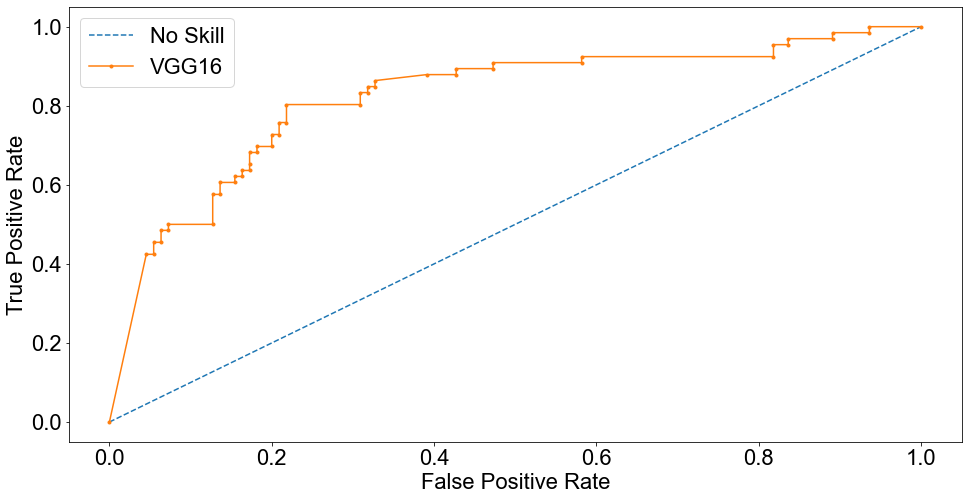

In [43]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_true))]
# keep probabilities for the positive outcome only
lr_probs = pred
# calculate scores
ns_auc = roc_auc_score(y_true, ns_probs)
lr_auc = roc_auc_score(y_true, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('VGG16: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_true, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='VGG16')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

### Precision-Recall Curve

In [44]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true, pred)

VGG16: f1=0.702 auc=0.766


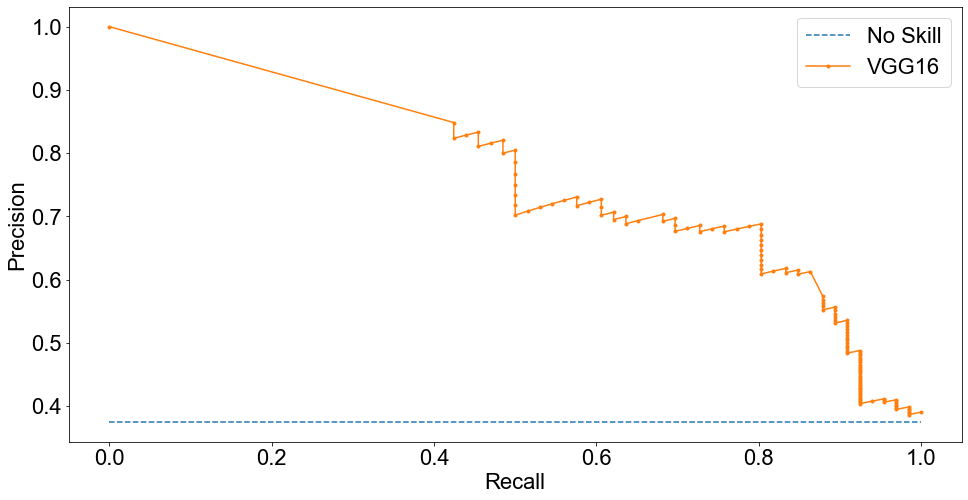

In [45]:
from sklearn.metrics import auc

# predict probabilities
lr_probs = pred
# predict class values
yhat = y_pred
lr_precision, lr_recall, _ = precision_recall_curve(y_true, lr_probs)
lr_f1, lr_auc = f1_score(y_true, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('VGG16: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_true[y_true==1]) / len(y_true)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='VGG16')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

### Two samples of the highest score photos and the lowest score photos

In [46]:
organic_test_photos_score = dict()
organic_folder = 'test\\organic\\'
len_bad = len(os.listdir(organic_folder + 'bad'))
for idx, image_file in enumerate(os.listdir(organic_folder + 'bad')):
    organic_test_photos_score[image_file] = pred[idx][0]
for idx, image_file in enumerate(os.listdir(organic_folder + 'good')):
    organic_test_photos_score[image_file] = pred[len_bad + idx][0]

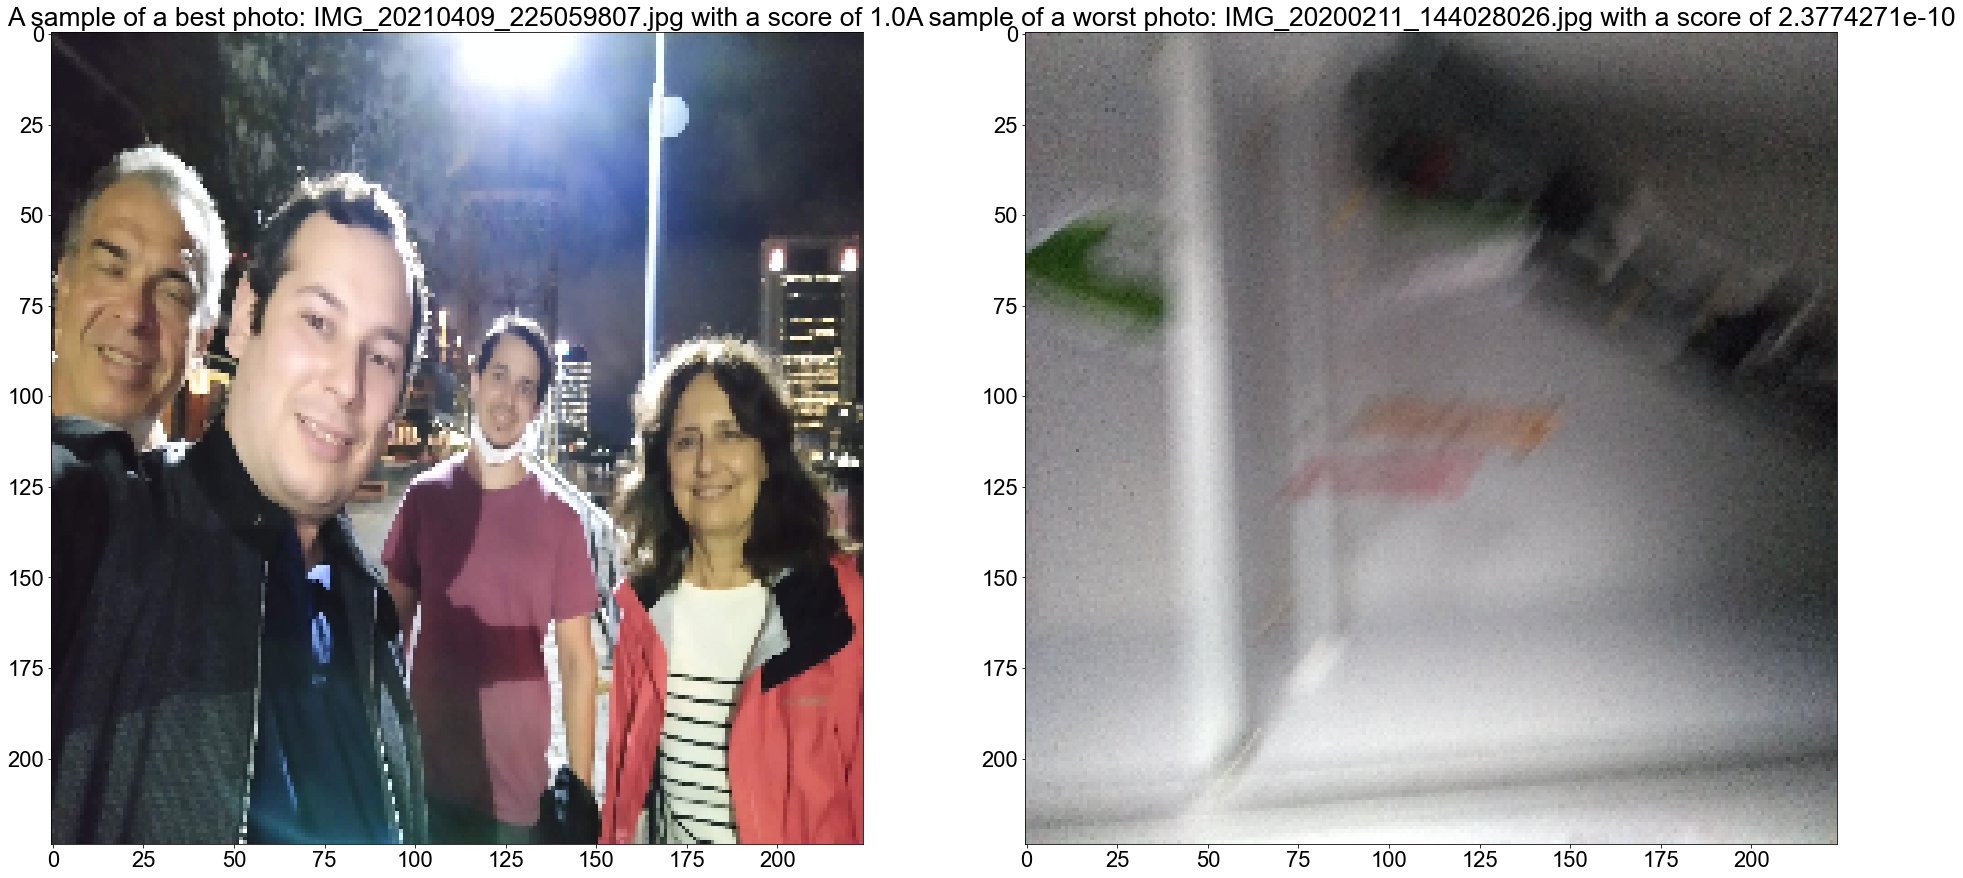

In [47]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 32 ,20

highest_score_photo = max(organic_test_photos_score, key= lambda x: organic_test_photos_score[x])

img = image.load_img(organic_folder + 'bad\\' + highest_score_photo, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
plt.subplot(1, 2, 1)
plt.title('A sample of a best photo: ' + highest_score_photo + ' with a score of ' + str(organic_test_photos_score[highest_score_photo]))
plt.imshow(img)

lowest_score_photo = min(organic_test_photos_score, key= lambda x: organic_test_photos_score[x])

img = image.load_img(organic_folder  + 'bad\\' + lowest_score_photo, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
plt.subplot(1, 2, 2)
plt.title('A sample of a worst photo: ' + lowest_score_photo + ' with a score of ' + str(organic_test_photos_score[lowest_score_photo]))
plt.imshow(img);

## Testing the model on good and synthetic-bad test data from the flicker30k collection

In [48]:
threshold = 0.5

In [49]:
from keras.preprocessing.image import ImageDataGenerator
img_gen = ImageDataGenerator(validation_split=0.2)

In [50]:
test_data = img_gen.flow_from_directory(
    'test\\synthetic',
    target_size=(224, 224),
    class_mode=None,
    shuffle=False,
)

Found 1400 images belonging to 2 classes.


In [51]:
pred = model.predict_generator(generator=test_data)

C:\Users\Eran\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [52]:
y_true = test_data.classes
y_pred = pred > threshold

### Confusion matrix

In [53]:
from sklearn.metrics import confusion_matrix

font = {
'family': 'Arial',
'size': 22
}
plt.rc('font', **font)
mat = confusion_matrix(y_true, y_pred)

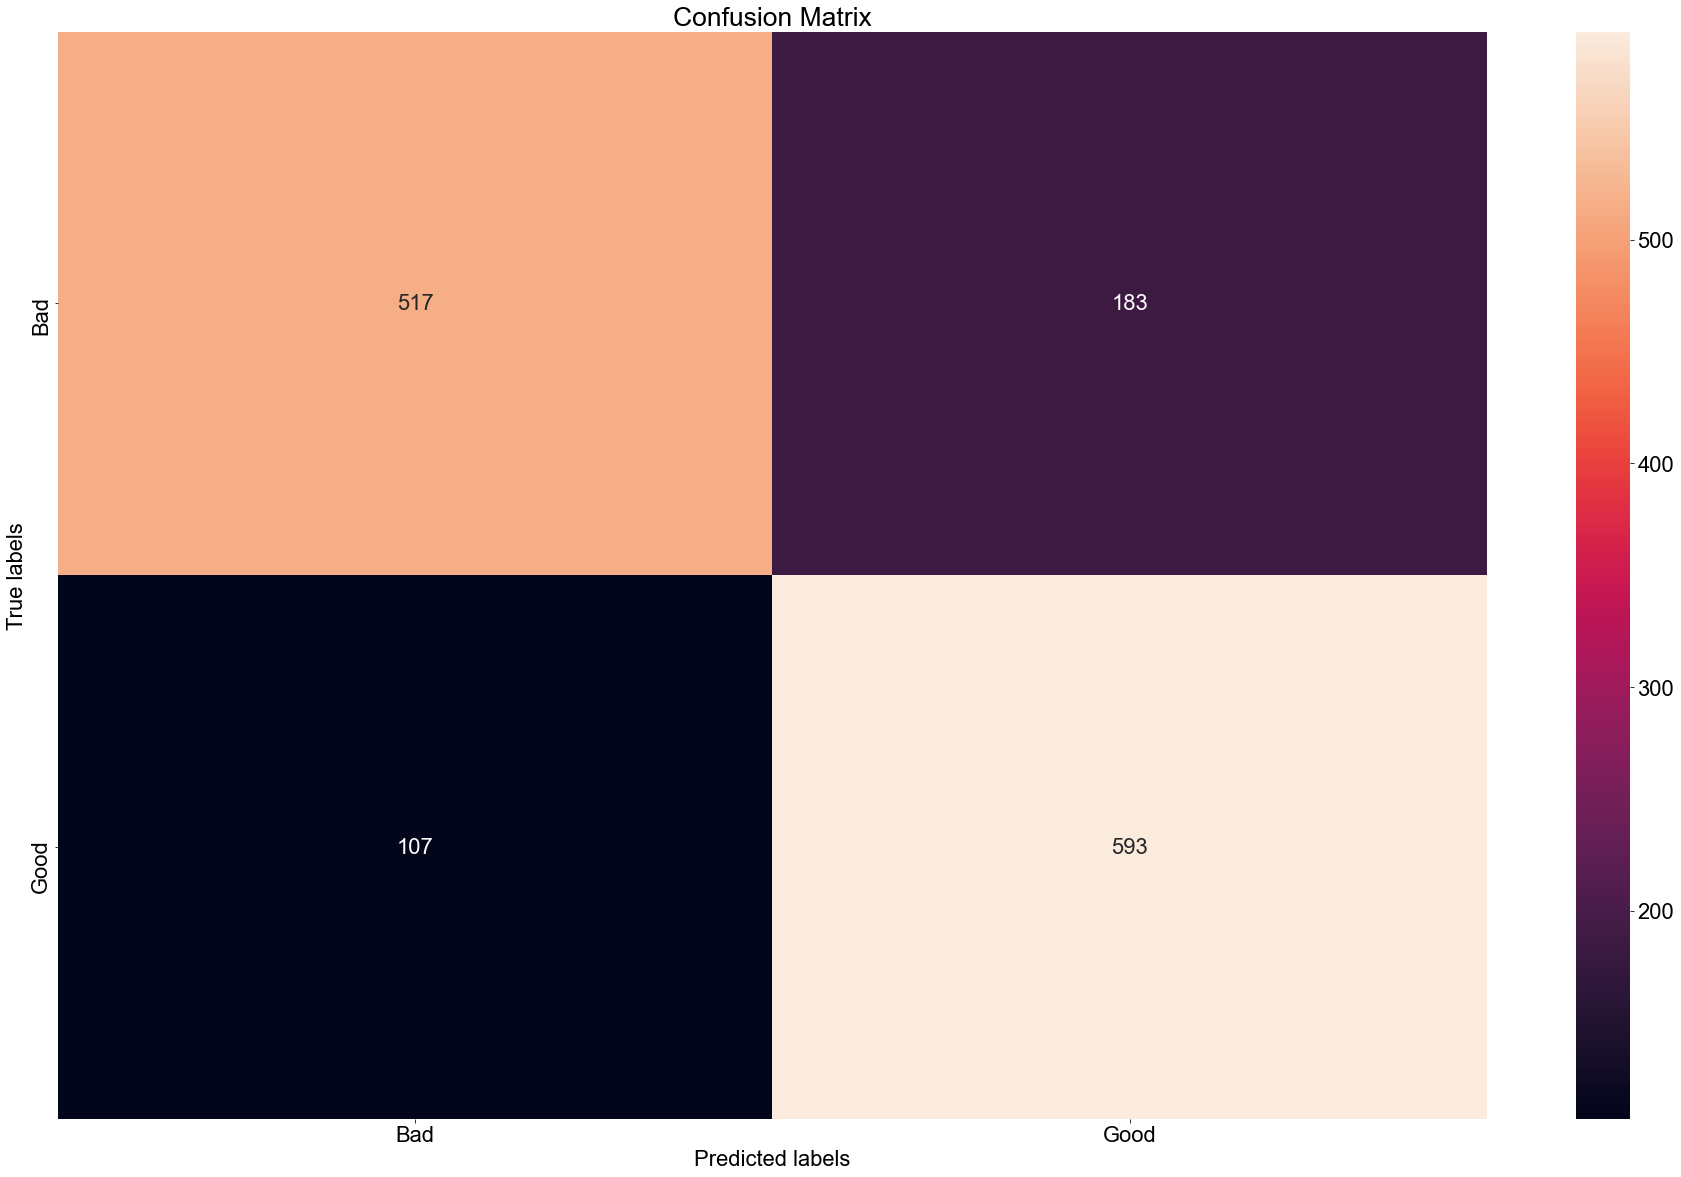

In [54]:
import seaborn as sns

ax= plt.subplot()
sns.heatmap(mat, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Bad', 'Good']); ax.yaxis.set_ticklabels(['Bad', 'Good']);

In [55]:
FP = mat[0][1]
FN = mat[1][0]
FP_rate = FP / (mat[0][0] + mat[0][1])
FN_rate = FN / (mat[1][0] + mat[1][1])
print('False Positive rate:', FP_rate)
print('False Negative rate:', FN_rate)

False Positive rate: 0.26142857142857145
False Negative rate: 0.15285714285714286


### Classification report

In [56]:
from sklearn.metrics import classification_report
target_names = ['bad', 'good']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         bad       0.83      0.74      0.78       700
        good       0.76      0.85      0.80       700

    accuracy                           0.79      1400
   macro avg       0.80      0.79      0.79      1400
weighted avg       0.80      0.79      0.79      1400



In [57]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.7928571428571428

In [58]:
from sklearn.metrics import recall_score
recall_score(y_true, y_pred)

0.8471428571428572

In [59]:
from sklearn.metrics import precision_score
precision_score(y_true, y_pred)

0.7641752577319587

In [60]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred)

0.8035230352303523

### ROC Curve and auc

In [61]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_true, pred)

In [62]:
# calculate AUC
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_true, pred)
print('AUC: %.3f' % auc)

AUC: 0.876


No Skill: ROC AUC=0.500
VGG16: ROC AUC=0.876


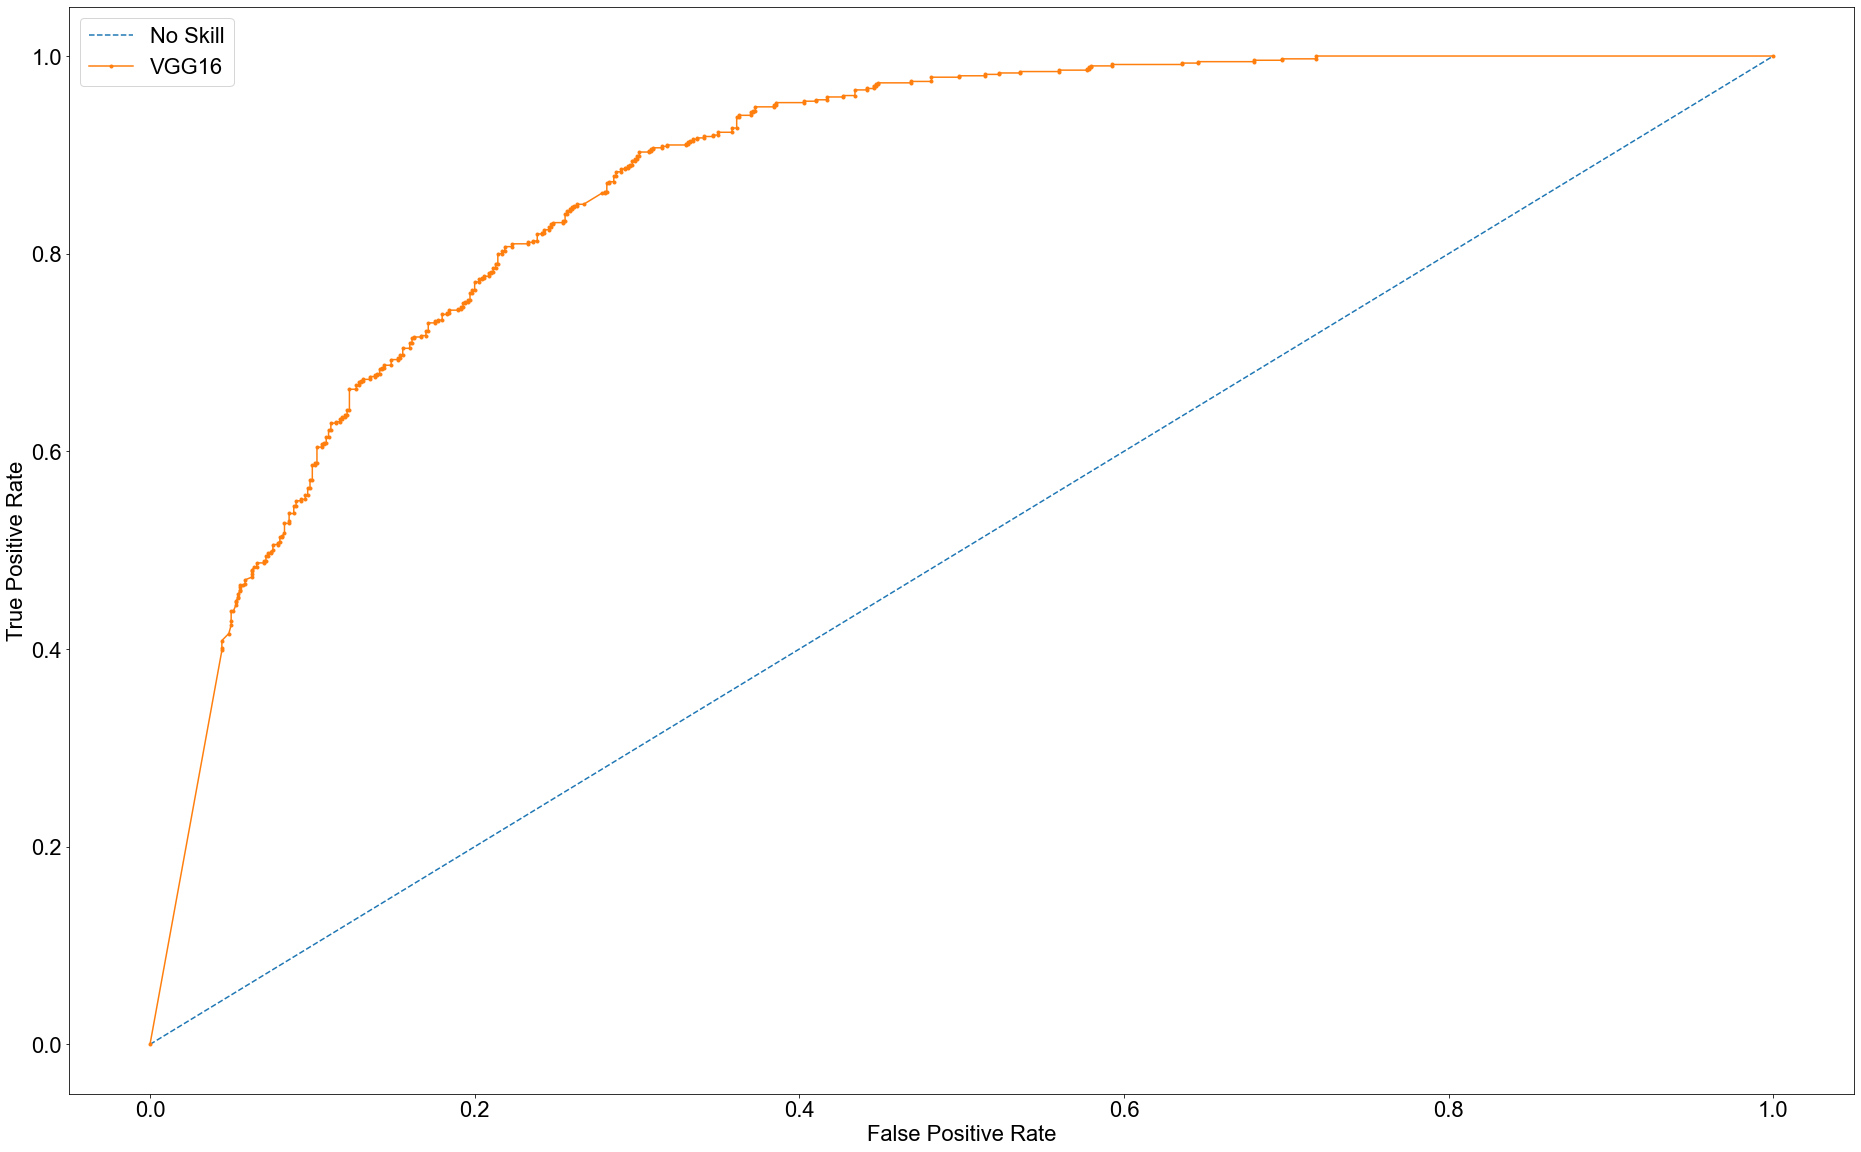

In [63]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_true))]
# keep probabilities for the positive outcome only
lr_probs = pred
# calculate scores
ns_auc = roc_auc_score(y_true, ns_probs)
lr_auc = roc_auc_score(y_true, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('VGG16: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_true, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='VGG16')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

### Precision-Recall Curve

In [64]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true, pred)

VGG16: f1=0.804 auc=0.864


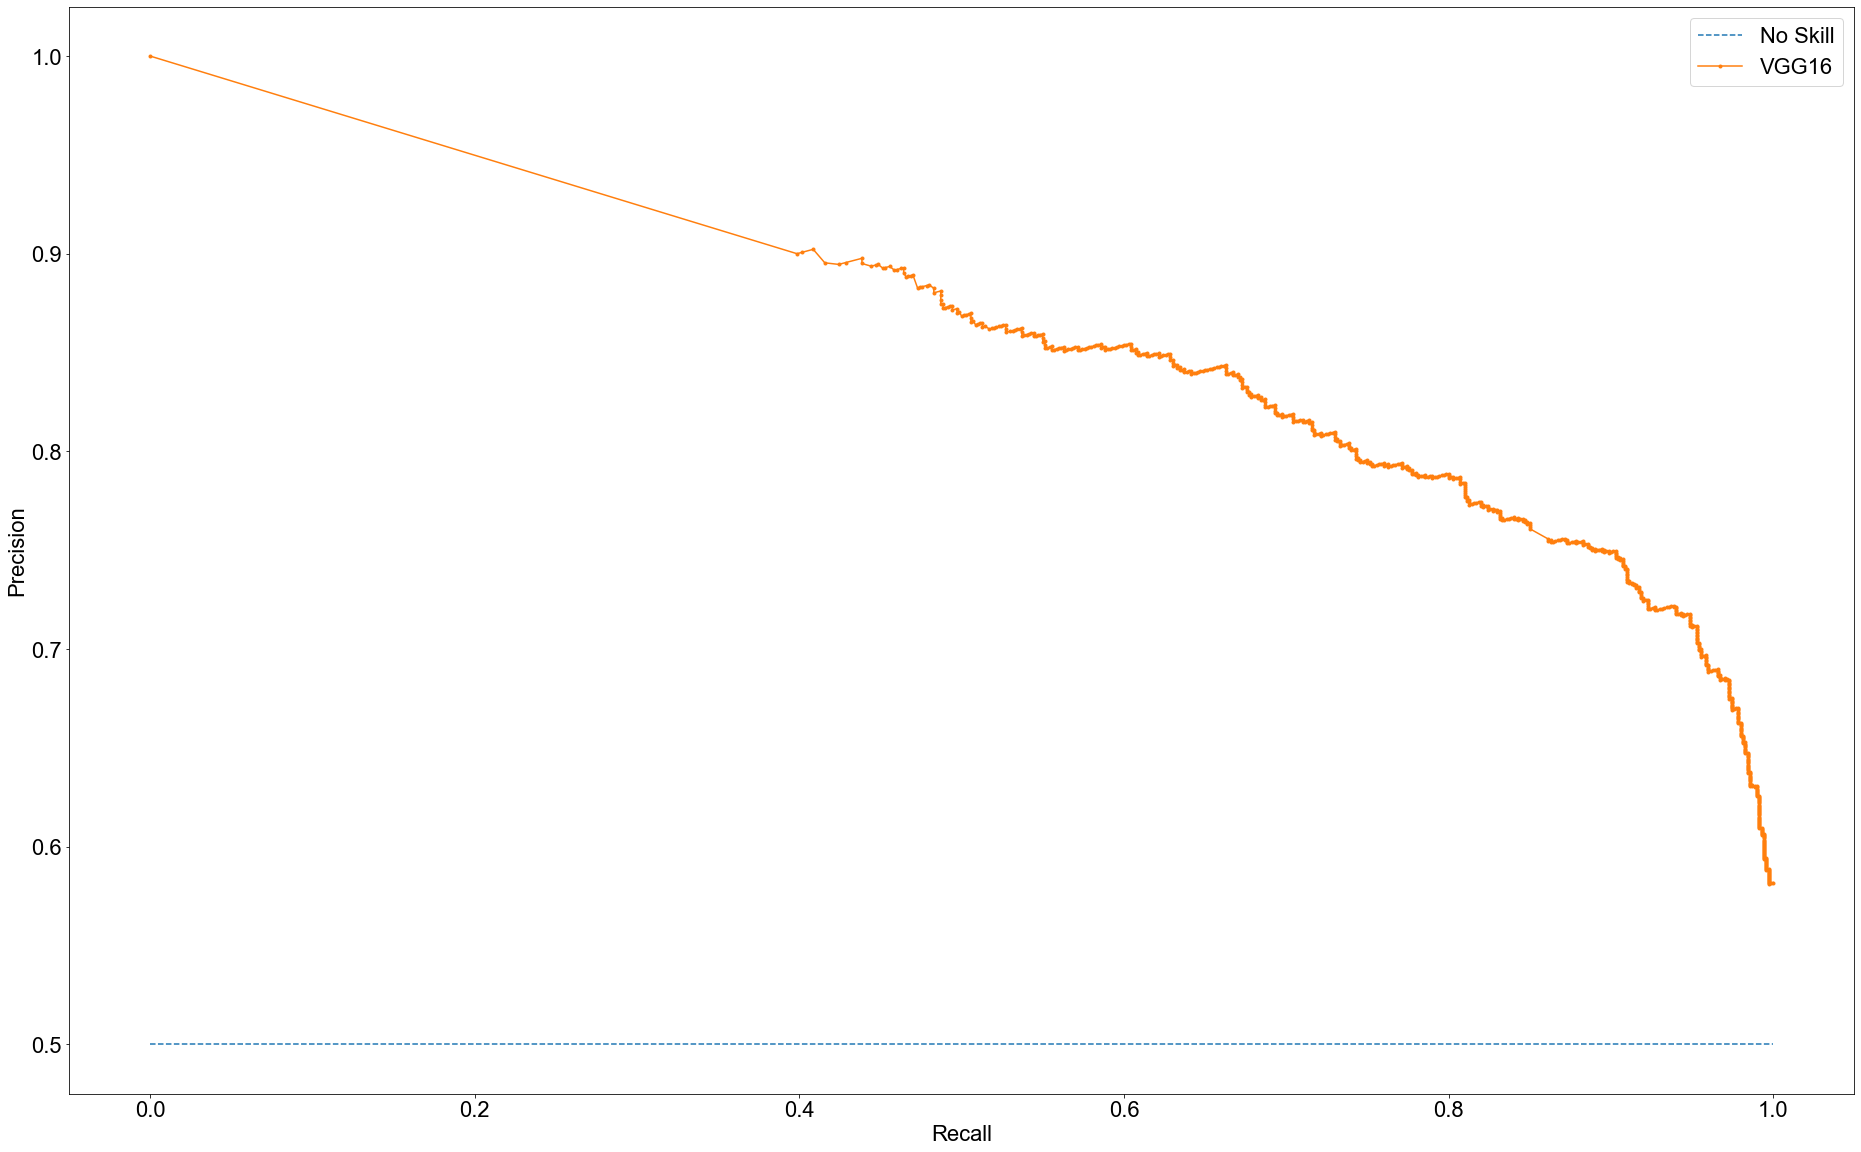

In [65]:
from sklearn.metrics import auc

# predict probabilities
lr_probs = pred
# predict class values
yhat = y_pred
lr_precision, lr_recall, _ = precision_recall_curve(y_true, lr_probs)
lr_f1, lr_auc = f1_score(y_true, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('VGG16: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_true[y_true==1]) / len(y_true)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='VGG16')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

### Two samples of the highest score photos and the lowest score photos

In [66]:
synthetic_test_photos_score = dict()
synthetic_folder = 'test\\synthetic\\'
len_bad = len(os.listdir(synthetic_folder + 'bad'))
for idx, image_file in enumerate(os.listdir(synthetic_folder + 'bad')):
    synthetic_test_photos_score[image_file] = pred[idx][0]
for idx, image_file in enumerate(os.listdir(synthetic_folder + 'good')):
    synthetic_test_photos_score[image_file] = pred[len_bad + idx][0]

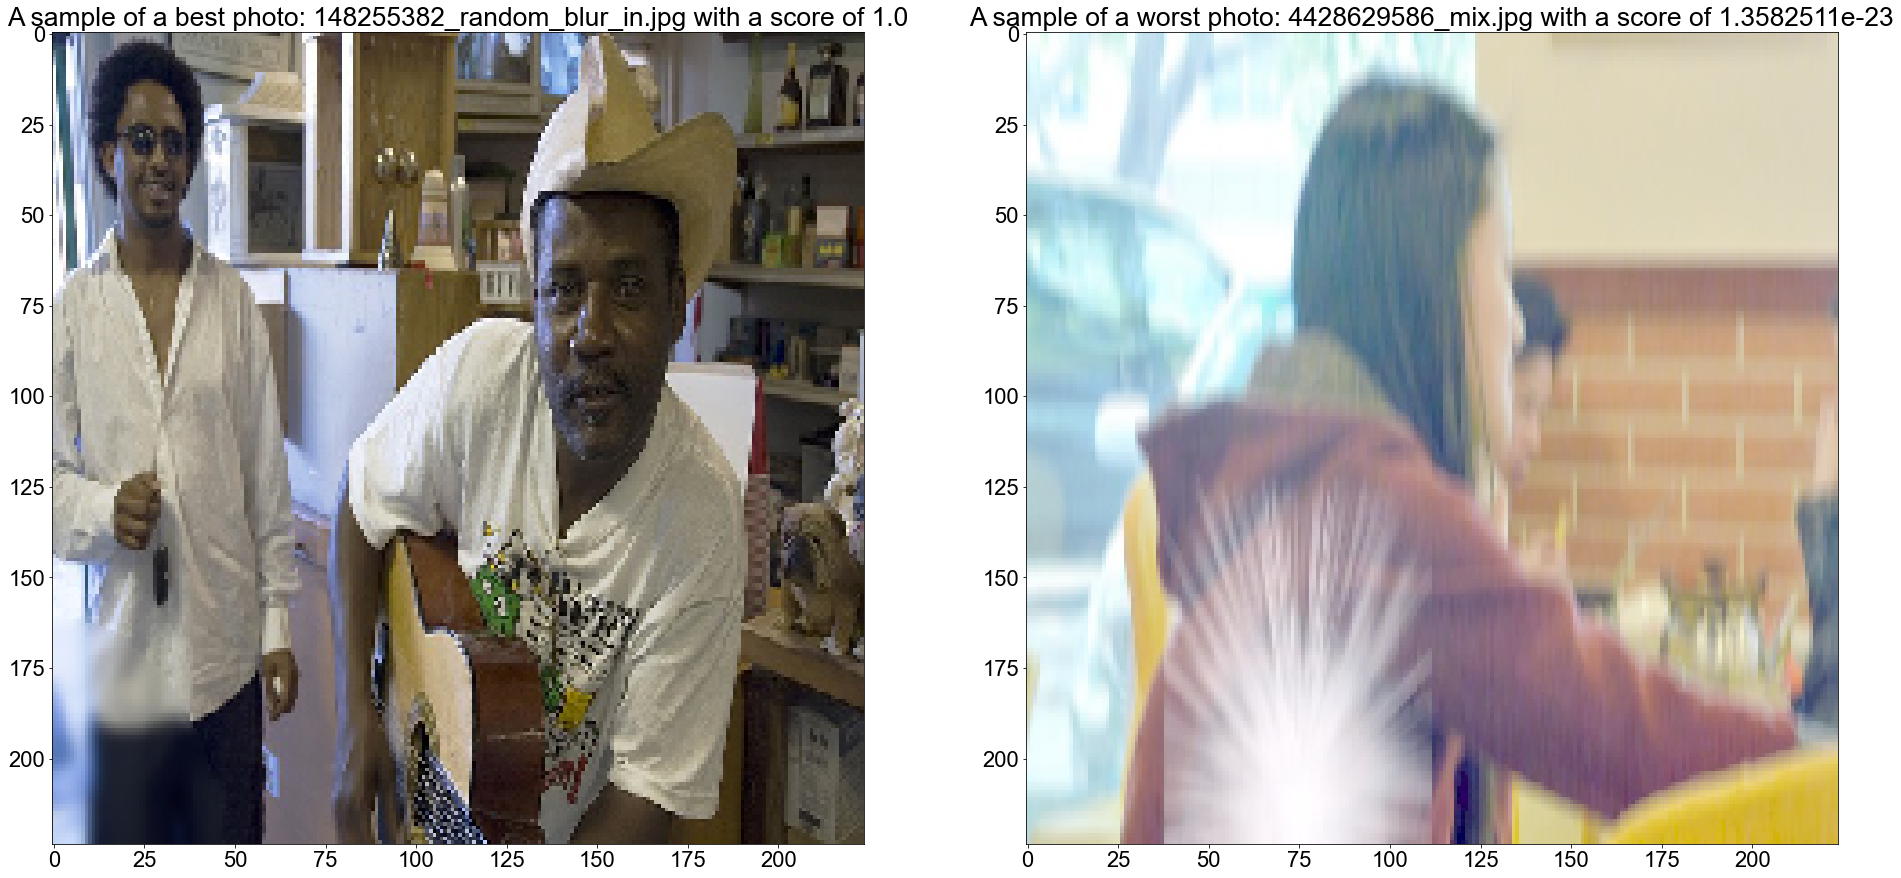

In [67]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 32 ,20

highest_score_photo = max(synthetic_test_photos_score, key= lambda x: synthetic_test_photos_score[x])

img = image.load_img(synthetic_folder + 'bad\\' + highest_score_photo, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
plt.subplot(1, 2, 1)
plt.title('A sample of a best photo: ' + highest_score_photo + ' with a score of ' + str(synthetic_test_photos_score[highest_score_photo]))
plt.imshow(img)

lowest_score_photo = min(synthetic_test_photos_score, key= lambda x: synthetic_test_photos_score[x])

img = image.load_img(synthetic_folder  + 'bad\\' + lowest_score_photo, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
plt.subplot(1, 2, 2)
plt.title('A sample of a worst photo: ' + lowest_score_photo + ' with a score of ' + str(synthetic_test_photos_score[lowest_score_photo]))
plt.imshow(img);